In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import os
from PIL import Image
import pyarrow.parquet as pq
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Set GPU configuration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("Using CPU")

TensorFlow version: 2.18.0
Using CPU


In [9]:
dataset_metadata = {
  "alzheimer_mri_dataset": None,  # Assuming this is a placeholder
  "author": "Falah.G.Salieh",
  "title": "Alzheimer MRI Dataset",
  "year": 2023,
  "publisher": "Hugging Face",
  "version": "1.0",
  "url": "https://huggingface.co/datasets/Falah/Alzheimer_MRI"
}

!pip install datasets

In [11]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Print the number of examples and the first few samples
print("Number of examples:", len(dataset))
print("Sample data:")
for example in dataset[:5]:
    print(example)

Number of examples: 5120
Sample data:
image
label


In [12]:
import opendatasets

opendatasets.download('https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset/data')

Skipping, found downloaded files in ".\alzheimer-mri-disease-classification-dataset" (use force=True to force download)


In [16]:
BASE_DIR = "C:/Users/Om/Desktop/OM/proj/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data"

# Disease labels
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

# Function to convert dictionary to image array
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

# Load training data
train_df = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train_df['img_arr'] = train_df['image'].apply(dict_to_image)
train_df.drop("image", axis=1, inplace=True)

# Load test data
test_df = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test_df['img_arr'] = test_df['image'].apply(dict_to_image)
test_df.drop("image", axis=1, inplace=True)

print("Training and test data loaded successfully.")

Training and test data loaded successfully.


In [17]:
# Check image shapes
train_image_shapes = train_df['img_arr'].apply(lambda x: x.shape).unique()
test_image_shapes = test_df['img_arr'].apply(lambda x: x.shape).unique()

print(f"Unique image shapes in training data: {train_image_shapes}")
print(f"Unique image shapes in test data: {test_image_shapes}")

Unique image shapes in training data: [(128, 128)]
Unique image shapes in test data: [(128, 128)]


In [18]:
# Convert lists of arrays to a single NumPy array
X_train = np.stack(train_df['img_arr'].values)  # Shape: (num_samples, 128, 128)
X_test = np.stack(test_df['img_arr'].values)    # Shape: (num_samples, 128, 128)

# Expand dimensions to add the channel dimension (grayscale)
X_train = X_train[..., np.newaxis]  # Shape: (num_samples, 128, 128, 1)
X_test = X_test[..., np.newaxis]    # Shape: (num_samples, 128, 128, 1)

# Extract labels
Y_train = train_df['label'].values
Y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (5120, 128, 128, 1)
Y_train shape: (5120,)
X_test shape: (1280, 128, 128, 1)
Y_test shape: (1280,)


In [19]:
# Split training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 4096
Validation set size: 1024


In [20]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [21]:
# Parameters
N_CLASSES = len(np.unique(Y_train))
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

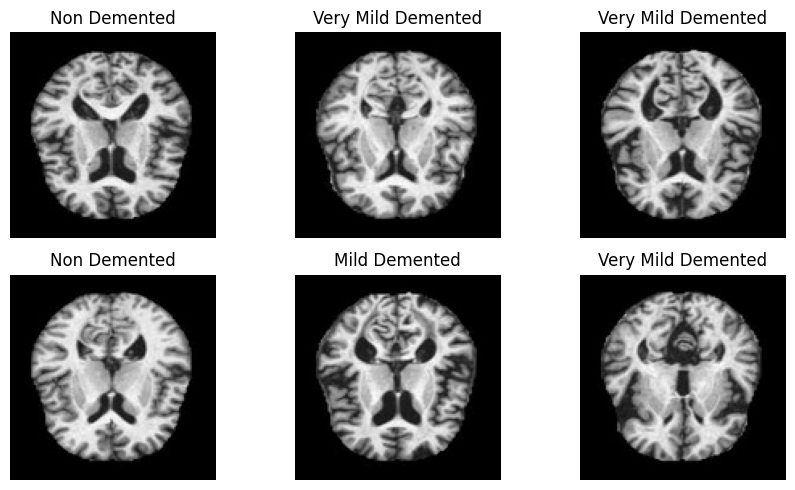

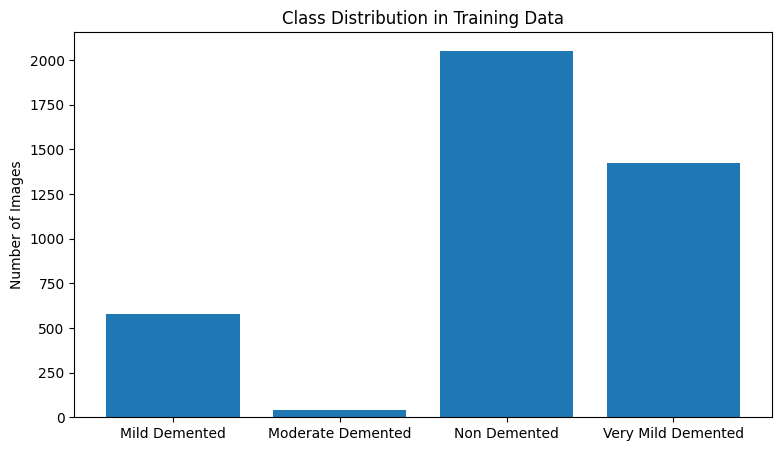

Total samples in training data = 4096


In [22]:
# Visualize sample images
fig, ax = plt.subplots(2, 3, figsize=(9, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(X_train))
    axes.imshow(X_train[rand].squeeze(), cmap="gray")
    axes.set_title(disease_label_from_category[Y_train[rand]])
    axes.axis('off')
plt.tight_layout()
plt.show()

# Class distribution
plt.figure(figsize=(9, 5))
plt.bar(np.arange(0, 4, 1), pd.Series(Y_train).value_counts().sort_index())
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[disease_label_from_category[i] for i in range(4)])
plt.title("Class Distribution in Training Data")
plt.show()

print(f"Total samples in training data = {X_train.shape[0]}")

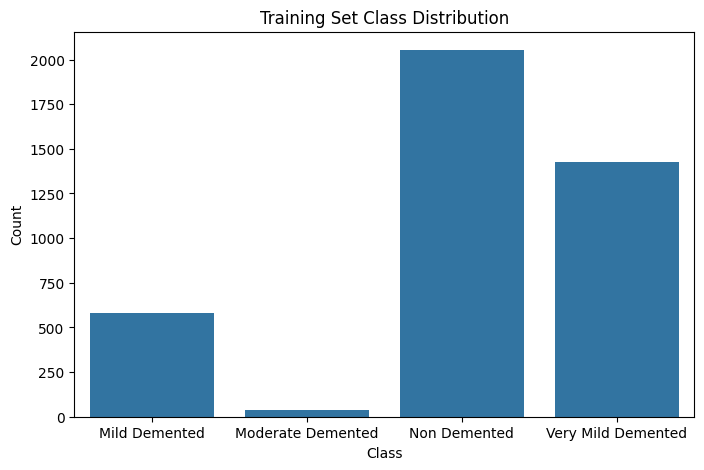

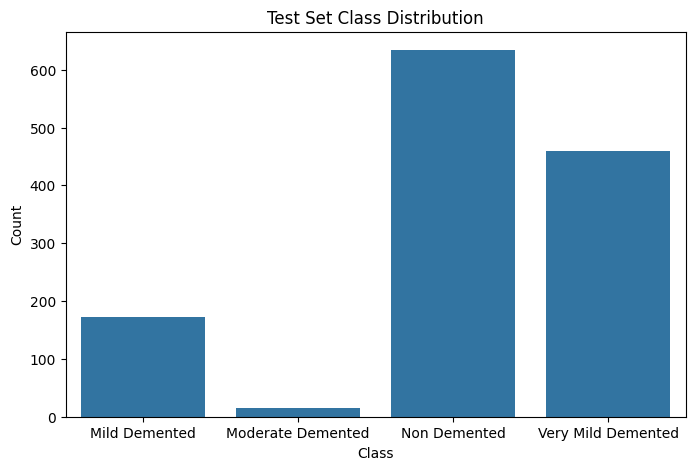

In [23]:
import seaborn as sns

# Function to plot class distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8,5))
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=range(len(disease_label_from_category)), 
               labels=[disease_label_from_category[i] for i in range(4)])
    plt.show()

# Plot distributions
plot_class_distribution(Y_train, "Training Set Class Distribution")
plot_class_distribution(Y_test, "Test Set Class Distribution")

In [27]:
# Define the Baseline CNN model
def create_baseline_cnn(input_shape=(128, 128, 1), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_cnn = create_baseline_cnn()
baseline_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

baseline_cnn.summary()

# Plot the model architecture
plot_model(baseline_cnn, show_shapes=True, show_layer_names=True)

c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,452 (32.08 MB)

 Trainable params: 8,408,260 (32.07 MB)

 Non-trainable params: 192 (768.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [29]:
# Define callbacks
# Save the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="baseline_cnn.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=5,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the model
history_baseline = baseline_cnn.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/30


128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.7437 - loss: 0.6078 - val_accuracy: 0.5762 - val_loss: 0.9006
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.7927 - loss: 0.4919 - val_accuracy: 0.5742 - val_loss: 0.8674
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.8953 - loss: 0.2976 - val_accuracy: 0.8057 - val_loss: 0.4799
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 230ms/step - accuracy: 0.9561 - loss: 0.1572 - val_accuracy: 0.8037 - val_loss: 0.4555
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.9699 - loss: 0.1084 - val_accuracy: 0.9395 - val_loss: 0.2022
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.9715 - loss: 0.0951 - val_accuracy: 0.9355 - val_loss: 0.1974
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.9913 - loss: 0.0400 - val_accuracy: 0.9443 - val_loss: 0.1680
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 235ms/step - accuracy: 0.9991 - loss: 0.0299 - val

In [30]:
# Load the best model
baseline_cnn.load_weights("baseline_cnn.keras")

# Evaluate on training data (not recommended for final evaluation)
train_predictions = baseline_cnn.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Y_train

print("Training Accuracy:", accuracy_score(train_true_labels, train_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(train_true_labels, train_pred_labels))
print("\nClassification Report:")
print(classification_report(train_true_labels, train_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

# Evaluate on test data
test_predictions = baseline_cnn.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = Y_test

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels, test_pred_labels))
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=[disease_label_from_category[i] for i in range(4)]))

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
Training Accuracy: 0.40185546875
Confusion Matrix:
[[ 100    6  291  182]
 [   6    0   21   12]
 [ 265   22 1041  725]
 [ 209   11  700  505]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.17      0.17      0.17       579
 Moderate Demented       0.00      0.00      0.00        39
      Non Demented       0.51      0.51      0.51      2053
Very Mild Demented       0.35      0.35      0.35      1425

          accuracy                           0.40      4096
         macro avg       0.26      0.26      0.26      4096
      weighted avg       0.40      0.40      0.40      4096

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Test Accuracy: 0.96015625
Confusion Matrix:
[[154   0   1  17]
 [  0  11   4   0]
 [  0   0 619  15]
 [  2   0  12 445]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.99      0.90      0.94       172
 

In [31]:
# Define data augmentation layers
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.GaussianNoise(0.1)
])

# Define a new model that includes data augmentation
def create_augmented_cnn(input_shape=(128, 128, 1), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

augmented_cnn = create_augmented_cnn()
augmented_cnn.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

augmented_cnn.summary()

# Plot the model architecture
plot_model(augmented_cnn, show_shapes=True, show_layer_names=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,408,452 (32.08 MB)

 Trainable params: 8,408,260 (32.07 MB)

 Non-trainable params: 192 (768.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
# Define callbacks
checkpoint_cb_aug = ModelCheckpoint(
    filepath="augmented_cnn.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb_aug = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=10,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the augmented model
history_augmented = augmented_cnn.fit(
    train_ds,
    epochs=30, 
    validation_data=val_ds,
    callbacks=[checkpoint_cb_aug, earlystop_cb_aug]
)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.4290 - loss: 9.3708 - val_accuracy: 0.5010 - val_loss: 1.6276
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.5169 - loss: 1.0273 - val_accuracy: 0.5010 - val_loss: 2.4624
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.5357 - loss: 0.9440 - val_accuracy: 0.5010 - val_loss: 3.4996
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.5288 - loss: 0.9464 - val_accuracy: 0.5010 - val_loss: 2.9745
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.5481 - loss: 0.9365 - val_accuracy: 0.5068 - val_loss: 2.0724
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.5403 - loss: 0.9232 - val_accuracy: 0.5205 - val_loss: 1.6991
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.5434 - loss: 0.9447 - val_accuracy: 0.5195 - val_loss: 1.1992
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.5489 - loss: 0

In [34]:
# Load the best augmented model
augmented_cnn.load_weights("augmented_cnn.keras")

# Evaluate on training data
train_predictions_aug = augmented_cnn.predict(train_ds)
train_pred_labels_aug = np.argmax(train_predictions_aug, axis=1)
train_true_labels_aug = Y_train

print("Augmented Training Accuracy:", accuracy_score(train_true_labels_aug, train_pred_labels_aug))
print("Confusion Matrix:")
print(confusion_matrix(train_true_labels_aug, train_pred_labels_aug))
print("\nClassification Report:")
print(classification_report(train_true_labels_aug, train_pred_labels_aug, target_names=[disease_label_from_category[i] for i in range(4)]))

# Evaluate on test data
test_predictions_aug = augmented_cnn.predict(test_ds)
test_pred_labels_aug = np.argmax(test_predictions_aug, axis=1)
test_true_labels_aug = Y_test

print("Augmented Test Accuracy:", accuracy_score(test_true_labels_aug, test_pred_labels_aug))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels_aug, test_pred_labels_aug))
print("\nClassification Report:")
print(classification_report(test_true_labels_aug, test_pred_labels_aug, target_names=[disease_label_from_category[i] for i in range(4)]))

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Augmented Training Accuracy: 0.44677734375
Confusion Matrix:
[[   0    0  319  260]
 [   0    0   23   16]
 [   0    0 1214  839]
 [   0    0  809  616]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       579
 Moderate Demented       0.00      0.00      0.00        39
      Non Demented       0.51      0.59      0.55      2053
Very Mild Demented       0.36      0.43      0.39      1425

          accuracy                           0.45      4096
         macro avg       0.22      0.26      0.23      4096
      weighted avg       0.38      0.45      0.41      4096

 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Augmented Test Accuracy: 0.565625
Confusion Matrix:
[[  0   0  39 133]
 [  0   0   2  13]
 [  0   0 484 150]
 [  0   0 219 240]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       172
 Moderate Demented       0.00      0.00      0.00        15
      Non Demented       0.65      0.76      0.70       634
Very Mild Demented       0.45      0.52      0.48       459

          accuracy                           0.57      1280
         macro avg       0.27      0.32      0.30      1280
      weighted avg       0.48      0.57      0.52      1280



c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [35]:
import tensorflow as tf

# Function to convert grayscale to RGB using TensorFlow's built-in function
def grayscale_to_rgb_tf(img):
    return tf.image.grayscale_to_rgb(img)

# Function to preprocess images for transfer learning
def preprocess_image_rgb_tf(img, label):
    img = grayscale_to_rgb_tf(img)
    img = tf.image.resize(img, [224, 224])  # Resize to match ResNet50 input
    return img, label

# Function to apply normalization
def preprocess_transfer_tf(img, lbl):
    img, lbl = preprocess_image_rgb_tf(img, lbl)
    img = img / 255.0  # Normalize to [0,1]
    return img, lbl

# Create TensorFlow datasets for transfer learning
train_ds_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds_tf = train_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_tf = train_ds_tf.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds_tf = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds_tf = val_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_tf = val_ds_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds_tf = test_ds_tf.map(preprocess_transfer_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_tf = test_ds_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [36]:
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Define the transfer learning model
def create_transfer_learning_model(base_model, num_classes=4):
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_model = create_transfer_learning_model(base_model)
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

# Plot the model architecture
plot_model(transfer_model, show_shapes=True, show_layer_names=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [39]:
# Define callbacks
checkpoint_cb_tf = ModelCheckpoint(
    filepath="transfer_learning_resnet50.keras",  # File path to save the model
    save_best_only=True,            # Only save when the model is better
    monitor='val_accuracy',         # Metric to monitor
    mode='max',                     # Mode: 'max' for accuracy
    verbose=0                       # Verbosity mode
)
# Stop training when validation accuracy doesn't improve for 5 epochs
earlystop_cb_tf = EarlyStopping(
    monitor='val_accuracy',         # Metric to monitor
    patience=10,                     # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored metric
    mode='max',                     # Mode: 'max' for accuracy
    verbose=1                       # Verbosity mode
)

# Train the transfer learning model
history_transfer = transfer_model.fit(
    train_ds_tf,
    epochs=30,
    validation_data=val_ds_tf,
    callbacks=[checkpoint_cb_tf, earlystop_cb_tf]
)

Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.4842 - loss: 1.0492 - val_accuracy: 0.5010 - val_loss: 1.0417
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5068 - loss: 1.0446 - val_accuracy: 0.5010 - val_loss: 1.0391
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4995 - loss: 1.0496 - val_accuracy: 0.5010 - val_loss: 1.0375
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.5065 - loss: 1.0478 - val_accuracy: 0.5010 - val_loss: 1.0367
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4993 - loss: 1.0346 - val_accuracy: 0.5010 - val_loss: 1.0364
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4985 - loss: 1.0496 - val_accuracy: 0.5010 - val_loss: 1.0377
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4940 - loss: 1.0533 - val_accuracy: 0.5010 - val_loss: 1.0382
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5096 - loss: 1.0338 - val_accu

In [42]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze some layers and leave others trainable
# Freeze all layers except the last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Continue training
history_finetune = transfer_model.fit(
    train_ds_tf,
    epochs=5,
    validation_data=val_ds_tf,
    callbacks=[checkpoint_cb_tf, earlystop_cb_tf]
)

Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.4726 - loss: 1.0677 - val_accuracy: 0.5010 - val_loss: 1.0606
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.4943 - loss: 1.0543 - val_accuracy: 0.5010 - val_loss: 1.0668
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.4931 - loss: 1.0513 - val_accuracy: 0.5010 - val_loss: 1.0450
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.4946 - loss: 1.0546 - val_accuracy: 0.5010 - val_loss: 1.0364
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.4986 - loss: 1.0493 - val_accuracy: 0.5010 - val_loss: 1.0370
Restoring model weights from the end of the best epoch: 1.


In [43]:
# Load the best transfer learning model
transfer_model.load_weights("transfer_learning_resnet50.keras")

# Evaluate on test data
test_predictions_tf = transfer_model.predict(test_ds_tf)
test_pred_labels_tf = np.argmax(test_predictions_tf, axis=1)
test_true_labels_tf = Y_test

print("Transfer Learning Test Accuracy:", accuracy_score(test_true_labels_tf, test_pred_labels_tf))
print("Confusion Matrix:")
print(confusion_matrix(test_true_labels_tf, test_pred_labels_tf))
print("\nClassification Report:")
print(classification_report(test_true_labels_tf, test_pred_labels_tf, target_names=[disease_label_from_category[i] for i in range(4)]))

c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 130 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Transfer Learning Test Accuracy: 0.4953125
Confusion Matrix:
[[  0   0 172   0]
 [  0   0  15   0]
 [  0   0 634   0]
 [  0   0 459   0]]

Classification Report:
                    precision    recall  f1-score   support

     Mild Demented       0.00      0.00      0.00       172
 Moderate Demented       0.00      0.00      0.00        15
      Non Demented       0.50      1.00      0.66       634
Very Mild Demented       0.00      0.00      0.00       459

          accuracy                           0.50      1280
         macro avg       0.12      0.25      0.17      1280
      weighted avg       0.25      0.50      0.33      1280



c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

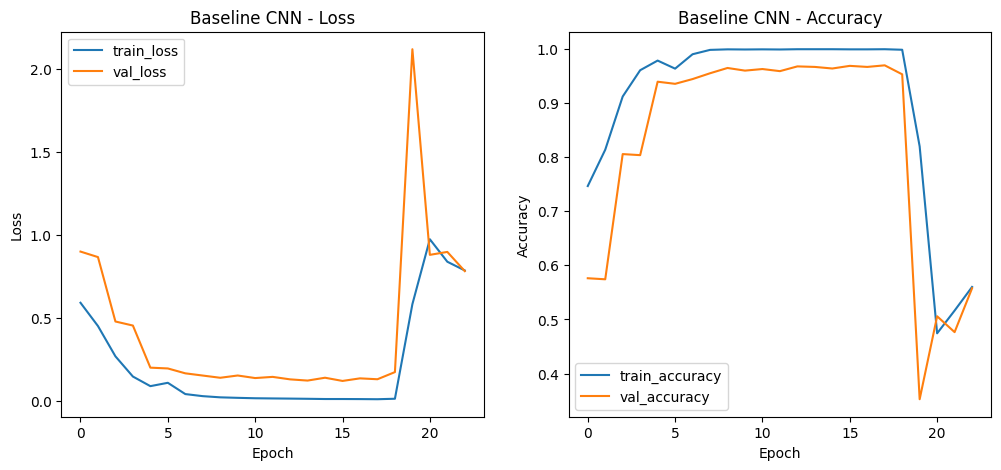

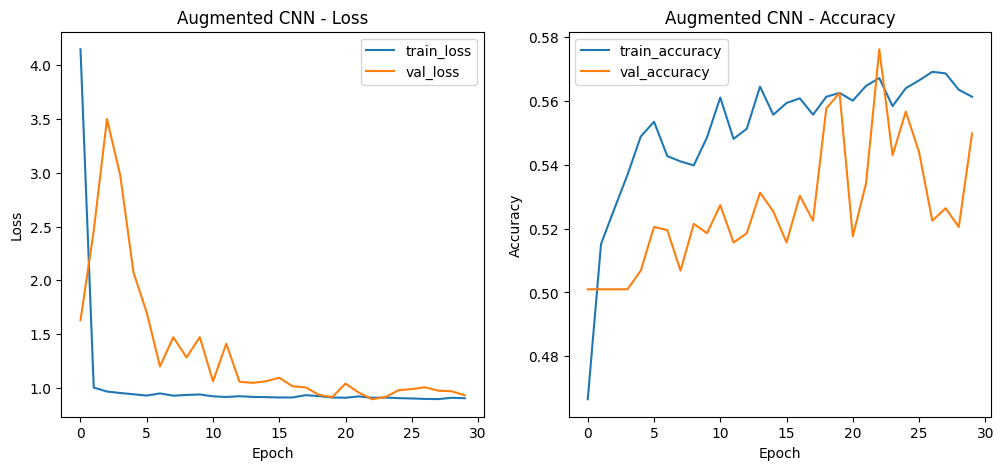

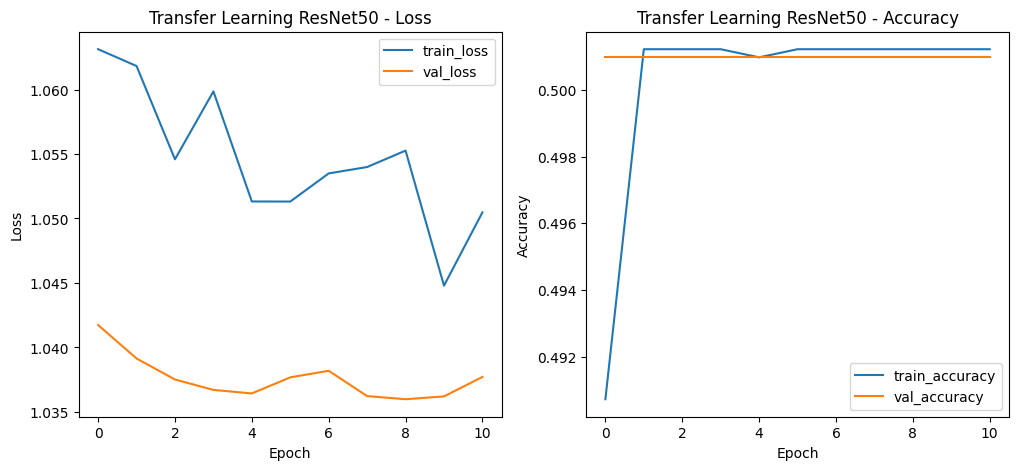

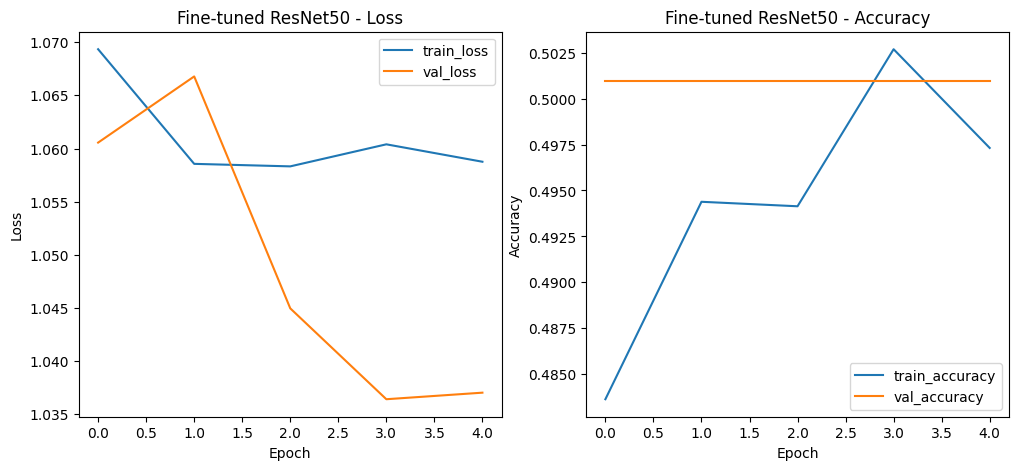

In [44]:
# Function to plot training history
def plot_history(hist, title):
    plt.figure(figsize=(12,5))
    
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train_accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Plot histories
plot_history(history_baseline, "Baseline CNN")
plot_history(history_augmented, "Augmented CNN")
plot_history(history_transfer, "Transfer Learning ResNet50")
plot_history(history_finetune, "Fine-tuned ResNet50")

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the best model
baseline_cnn.load_weights("baseline_cnn.keras")

# Predict on training data
train_predictions = baseline_cnn.predict(train_ds)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Y_train

# Predict on test data
test_predictions = baseline_cnn.predict(test_ds)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = Y_test

# Calculate accuracies
baseline_train_acc = accuracy_score(train_true_labels, train_pred_labels)
baseline_test_acc = accuracy_score(test_true_labels, test_pred_labels)

# Generate classification reports
baseline_train_report = classification_report(train_true_labels, train_pred_labels, output_dict=True)
baseline_test_report = classification_report(test_true_labels, test_pred_labels, output_dict=True)

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [46]:
# Load the best augmented model
augmented_cnn.load_weights("augmented_cnn.keras")

# Predict on training data
train_predictions_aug = augmented_cnn.predict(train_ds)
train_pred_labels_aug = np.argmax(train_predictions_aug, axis=1)
train_true_labels_aug = Y_train

# Predict on test data
test_predictions_aug = augmented_cnn.predict(test_ds)
test_pred_labels_aug = np.argmax(test_predictions_aug, axis=1)
test_true_labels_aug = Y_test

# Calculate accuracies
augmented_train_acc = accuracy_score(train_true_labels_aug, train_pred_labels_aug)
augmented_test_acc = accuracy_score(test_true_labels_aug, test_pred_labels_aug)

# Generate classification reports
augmented_train_report = classification_report(train_true_labels_aug, train_pred_labels_aug, output_dict=True)
augmented_test_report = classification_report(test_true_labels_aug, test_pred_labels_aug, output_dict=True)

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [47]:
# Load the best transfer learning model
transfer_model.load_weights("transfer_learning_resnet50.keras")

# Predict on training data
train_predictions_tf = transfer_model.predict(train_ds_tf)
train_pred_labels_tf = np.argmax(train_predictions_tf, axis=1)
train_true_labels_tf = Y_train

# Predict on test data
test_predictions_tf = transfer_model.predict(test_ds_tf)
test_pred_labels_tf = np.argmax(test_predictions_tf, axis=1)
test_true_labels_tf = Y_test

# Calculate accuracies
transfer_train_acc = accuracy_score(train_true_labels_tf, train_pred_labels_tf)
transfer_test_acc = accuracy_score(test_true_labels_tf, test_pred_labels_tf)

# Generate classification reports
transfer_train_report = classification_report(train_true_labels_tf, train_pred_labels_tf, output_dict=True)
transfer_test_report = classification_report(test_true_labels_tf, test_pred_labels_tf, output_dict=True)

c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 130 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


128/128 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Om\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [48]:
import pandas as pd

# Create a dictionary to hold the summary
summary_data = {
    "Method": [
        "Baseline CNN",
        "CNN with Data Augmentation",
        "Transfer Learning (ResNet50)"
    ],
    "Training Accuracy": [
        f"{baseline_train_acc * 100:.2f}%",
        f"{augmented_train_acc * 100:.2f}%",
        f"{transfer_train_acc * 100:.2f}%"
    ],
    "Validation Accuracy": [
        f"{baseline_cnn.evaluate(val_ds, verbose=0)[1] * 100:.2f}%",
        f"{augmented_cnn.evaluate(val_ds, verbose=0)[1] * 100:.2f}%",
        f"{transfer_model.evaluate(val_ds_tf, verbose=0)[1] * 100:.2f}%"
    ],
    "Test Accuracy": [
        f"{baseline_test_acc * 100:.2f}%",
        f"{augmented_test_acc * 100:.2f}%",
        f"{transfer_test_acc * 100:.2f}%"
    ]
}

# Create the DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("Summary of Results")
summary_df

Summary of Results


,Method,Training Accuracy,Validation Accuracy,Test Accuracy
0,Baseline CNN,38.72%,96.97%,96.02%
1,CNN with Data Augmentation,43.82%,57.62%,56.56%
2,Transfer Learning (ResNet50),50.12%,50.10%,49.53%
